#ATSC 507 Final

In [1]:
__author__ = 'Yingkai (Kyle) Sha'
__email__  = 'yingkai@eos.ubc.ca'

In [2]:
from IPython.core.display import HTML
HTML(open("../custom.css", "r").read());

# Content
1. [**Modules and tools**](#Modules-and-tools)
1. [**Read WRF output**](#Read-WRF-output)
1. [**Mapping sets**](#Mapping-sets)
1. [**My simulation**](#My-simulation)
  2. [Nested domains](#Nested-domains)
  2. [About this case](#About-this-case)
1. [**Movies**](#Movies)
  2. [500hPa GPH isoline + shaded Temp. + Wind barbs](#500hPa-GPH-isoline-+-shaded-Temp.-+-Wind barbs)
  2. [SLP + shaded 2m Temp. + 10m Wind barbs](#SLP-+-shaded-2m-Temp.-+-10m-Wind-barbs)
  2. [Accumulated Total Grid Scale Precipitation](#Accumulated-Total-Grid-Scale-Precipitation)
1. [**Meteogram**](#Meteogram)
  2. [Shanghai, PRC](#Shanghai,-PRC)
  2. [Tokyo, JP](#Tokyo,-JP)
  2. [Short summary](#Short-summary)

# Modules and tools

In [4]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import cm
from mpl_toolkits.basemap import Basemap
import matplotlib.animation as animation
% matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Shared functions

In [6]:
def init():
    plt.cla(); ax1=fig.gca()
    ax1.plot(1, 1,linewidth=0)

In [7]:
def draw_map(mapkeys, lc, lw):
    proj=Basemap(**mapkeys)
    # draw coast line
    proj.drawcoastlines(linewidth=1, color=lc, zorder=3)
    proj.drawcountries(linewidth=1, color=lc, zorder=3)
    proj.drawstates(linewidth=1, color=lc,zorder=3)
    proj.fillcontinents(color=[0.6, 0.9, 1.0], lake_color=None, ax=ax, zorder=0, alpha=None)
    parallels = np.arange(0, 90, 10); meridians = np.arange(0, 360, 10)
    proj.drawparallels(parallels, labels=[1, 0, 0, 1], fontsize=10, linewidth=lw)
    proj.drawmeridians(meridians, labels=[1, 0, 0, 1], fontsize=10, linewidth=lw)
    return proj    

In [8]:
# nonlinear colormap, borrowed from Robert Hetland <hetland@tamu.edu>, under MIT license.
# http://protracted-matter.blogspot.ca/2012/08/nonlinear-colormap-in-matplotlib.html
from numpy import *
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    name = 'nlcmap'    
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = asarray(levels, dtype='float64')
        self._x = self.levels / self.levels.max()
        self._y = linspace(0.0, 1.0, len(self.levels))
    def __call__(self, xi, alpha=1.0, **kw):
        """docstring for fname"""
        yi = interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

In [9]:
from scipy.spatial import cKDTree

def nearest_kdtree(nav_lon, nav_lat, lons, lats):
    #
    combined_x_y_arrays = np.dstack([nav_lon.ravel(), nav_lat.ravel()])[0]
    points_list = list(np.array([lons.T, lats.T]).T)
    #
    mytree = cKDTree(combined_x_y_arrays)
    dist, index_flat = mytree.query(points_list)
    x, y = np.unravel_index(index_flat, nav_lon.shape)
    return x, y

# Read WRF output

In [10]:
d01_obj = nc.Dataset('_data/ATSC 507 WRF IV/wrfout_d01_2015-04-10.nc')
d02_obj = nc.Dataset('_data/ATSC 507 WRF IV/wrfout_d02_2015-04-10.nc')

In [11]:
print(d01_obj.variables.keys())

[u'time', u'DateTime', u'year', u'month', u'day', u'hour', u'minute', u'pressure', u'eta', u'p_top', u'lat', u'lon', u'Z_sfc', u'SST', u'T_sfc', u'p_sfc', u'slp', u'T_2m', u'theta_2m', u'Td_2m', u'r_v_2m', u'q_2m', u'rh_2m', u'u_10m_gr', u'v_10m_gr', u'u_10m_tr', u'v_10m_tr', u'ws_10m', u'wd_10m', u'precip_g', u'precip_c', u'pblh', u'nest_p', u'r_cloud', u'r_rain', u'Z_p', u'T_p', u'theta_p', u'Td_p', u'r_v_p', u'q_p', u'rh_p', u'u_tr_p', u'v_tr_p', u'ws_p', u'wd_p', u'w_p', u'pvo_p', u'avo_p', u'SW_d', u'LW_d', u'albedo', u'SH', u'LH', u'u_star', u'LWP', u'IWP', u'LandMask', u'LandUse', u'SeaIce']


In [12]:
lat01 = d01_obj.variables['lat'][:]
lon01 = d01_obj.variables['lon'][:]
lat02 = d02_obj.variables['lat'][:]
lon02 = d02_obj.variables['lon'][:]
plev = d01_obj.variables['pressure'][:]

Time  = ['2015-04-10 06:00', '2015-04-10 09:00', '2015-04-10 12:00', \
         '2015-04-10 15:00', '2015-04-10 18:00', '2015-04-10 21:00',\
         '2015-04-11 00:00', '2015-04-11 03:00', '2015-04-11 06:00']

# Mapping sets

In [13]:
latlim01  = [lat01.min()-4, lat01.max()+4]
lonlim01  = [lon01.min()-4, lon01.max()+4]
latlim02 = [lat02.min()+10, lat02.max()-2.5]
lonlim02 = [lon02.min()+10, lon02.max()-2.5]
coor_sh = [121.5, 31.2]
coor_tk = [139.75, 35.75]

In [14]:
mapkeys01=dict(projection='merc',\
             llcrnrlon=lonlim01[0], llcrnrlat=latlim01[0],\
             urcrnrlon=lonlim01[1], urcrnrlat=latlim01[1],\
             resolution='l', area_thresh=10000)
mapkeys02=dict(projection='merc',\
             llcrnrlon=lonlim02[0], llcrnrlat=latlim02[0],\
             urcrnrlon=lonlim02[1], urcrnrlat=latlim02[1],\
             resolution='i')
SIGN = 'Created by Yingkai (Kyle) Sha.\nFor ATSC-507 Final only.'

# My simulation

The simulation is operated as:
* From 10-Apr-2015 06:00 to 11-Apr-2015 09:00
* 180 seconds each timestep
* Double nested domain, 27 vertical layers
* 36/12km horizontal res. for two domains
* Two domains centered with city *Shanghai*

## Nested domains
The domain is shown by the figure below, and here I focused on the weather in *Shanghai* and *Tokyo*.

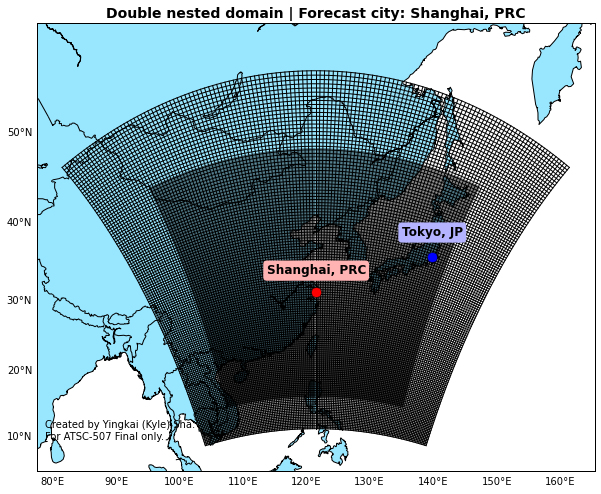

In [15]:
fig=plt.figure(figsize=(10, 10))
ax=fig.gca()
proj = draw_map(mapkeys01, 'k', 0)
# transfer from Lat/Lon to projected grid
x01, y01 = proj(lon01, lat01)
x02, y02 = proj(lon02, lat02)
shx, shy = proj(coor_sh[0], coor_sh[1])
tkx, tky = proj(coor_tk[0], coor_tk[1])
#
proj.plot(x01, y01, color='k', linewidth=1.0);
proj.plot(x01.T, y01.T, color='k', linewidth=1.0);
proj.plot(x02, y02, color='k', linewidth=0.6, alpha=0.5);
proj.plot(x02.T, y02.T, color='k', linewidth=0.6, alpha=0.5);
proj.plot(shx, shy, 'or', markersize=10, zorder=5)
plt.text(shx*0.825, shy*1.1, 'Shanghai, PRC', fontsize=12, fontweight='bold', \
         bbox=dict(facecolor=[1, 0.7, 0.7], edgecolor='none', boxstyle='round'))
proj.plot(tkx, tky, 'ob', markersize=10, zorder=5)
plt.text(tkx*0.925, tky*1.1, 'Tokyo, JP', fontsize=12, fontweight='bold', \
         bbox=dict(facecolor=[0.7, 0.7, 1], edgecolor='none', boxstyle='round'))
plt.text(x01[0, 0]*0.05, y01[0, 0]*1.25, SIGN, fontsize=10)
ax.set_title('Double nested domain | Forecast city: Shanghai, PRC', fontweight='bold', fontsize=14)

## About this case

A cyclone located on the North western Pacific transfers moist air and cause rain on the main part of Japan. On 500hPa layer, a trough is on the western side of the center of cyclone. *Shanghai* and *Tokyo* located on the western and eastern side of the 500hPa trough, and they have completely different weather conditions.

# Movies

##500hPa GPH isoline + shaded Temp. + Wind barbs

In [16]:
# d01
u01 = d01_obj.variables['u_tr_p'][:][:, plev==500, :, :]
v01 = d01_obj.variables['v_tr_p'][:][:, plev==500, :, :]
T01 = d01_obj.variables['T_p'][:][:, plev==500, :, :]-273.15 # unit: degC
Z01 = d01_obj.variables['Z_p'][:][:, plev==500, :, :]/10     # unit: 10GPM

In [17]:
Z500 = np.arange(500, 588+8, 8)
T500 = np.arange(-48, 4, 4)

In [18]:
def view1_movie_d01(time_step):
    plt.cla()
    ax1=fig.gca()
    proj = draw_map(mapkeys01, 'k', 0.5)
    # transfer from Lat/Lon to projected grid
    x01, y01 = proj(lon01, lat01)
    shx, shy = proj(coor_sh[0], coor_sh[1])
    tkx, tky = proj(coor_tk[0], coor_tk[1])
    proj.plot(shx, shy, 'or', markersize=12, zorder=5, label='Shanghai, PRC')
    proj.plot(tkx, tky, 'ob', markersize=12, zorder=5, label='Tokyo, JP')
    # GPH isoline
    CS1=proj.contour(x01, y01, Z01[time_step, 0, :, :], Z500, colors = ('k',), linewidths=3.5)
    plt.clabel(CS1, Z500, inline=1, fmt='%1.0f', fontsize=12, fontweight='bold')
    CS1.collections[0].set_label('GPH, unit: 10GPM')
    # Shaded Temp.
    CS2=proj.contourf(x01, y01, T01[time_step, 0, :, :], T500, cmap=plt.cm.coolwarm) # RdBu_r
    CBar=proj.colorbar(CS2, location='right', size='5%', pad='2%')
    CBar.set_label('500hPa Temperature ( $\mathrm{^\circ C}$ )', fontsize=10)
    CBar.ax.tick_params(axis='y', length=35)
    # Wind barb
    proj.barbs(x01[::10, ::10], y01[::10, ::10], \
               u01[time_step, 0, ::10, ::10], v01[time_step, 0, ::10, ::10], \
               length=6, barbcolor=[0.2, 0.2, 0.2], flagcolor='r', linewidth=1.5)
    # legend
    legend=plt.legend(numpoints=1, shadow=True, fancybox=True, fontsize=12); 
    frame=legend.get_frame(); frame.set_color('white') 
    # text, title
    plt.text(x01[0, 0]*0.05, y01[0, 0]*1.25, 'Time: '+Time[time_step], fontsize=10)
    plt.text(x01[0, 0]*0.05, y01[0, 0]*0.5, SIGN, fontsize=10)
    plt.title('500hPa GPH isoline + shaded Temp. + Wind barbs | d01 domain',\
                  fontweight='bold', fontsize=14)

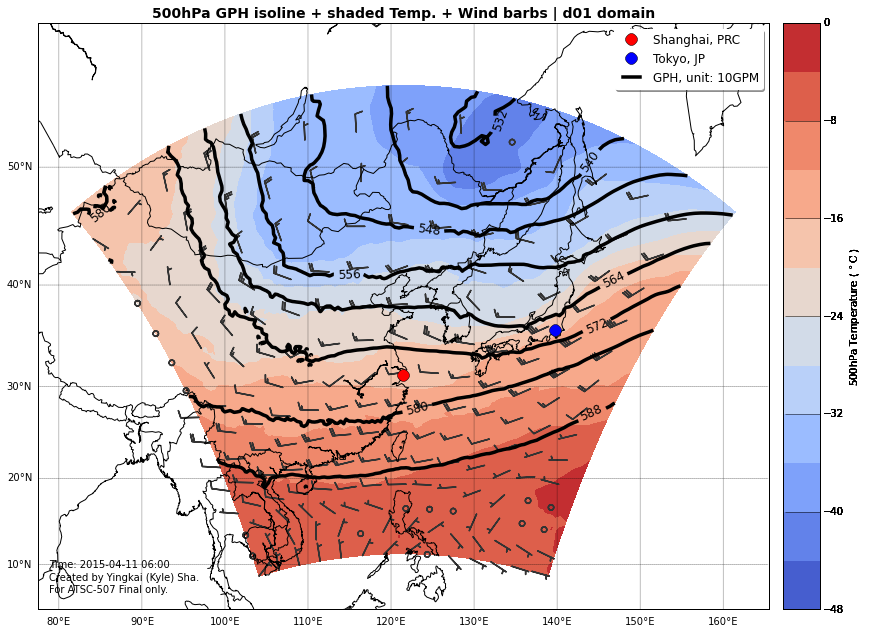

In [19]:
fig=plt.figure(figsize=(14, 14))
ani_obj=animation.FuncAnimation(fig, view1_movie_d01, range(9), \
                                init_func=init, interval=750, blit=True)
#writer_obj=animation.FFMpegFileWriter()
ani_obj.save('A507_Final_view1_d01.mov', metadata={'author':'Yingkai (Kyle) Sha'})

##SLP + shaded 2m Temp. + 10m Wind barbs

In [20]:
# d01
u01 = d01_obj.variables['u_10m_tr'][:]
v01 = d01_obj.variables['v_10m_tr'][:]
T01 = d01_obj.variables['T_2m'][:] # unit: degC
SLP01 = d01_obj.variables['slp'][:]
# d02
u02 = d02_obj.variables['u_10m_tr'][:]
v02 = d02_obj.variables['v_10m_tr'][:]
T02 = d02_obj.variables['T_2m'][:] # unit: degC
SLP02 = d02_obj.variables['slp'][:]

In [21]:
SLPlev = np.arange(1010, 1040+5, 5)
T2mlev = np.arange(-20, 30+4, 4)

In [22]:
def view2_movie_d01(time_step):
    plt.cla()
    ax1=fig.gca()
    proj = draw_map(mapkeys01, 'k', 0.5)
    # transfer from Lat/Lon to projected grid
    x01, y01 = proj(lon01, lat01)
    shx, shy = proj(coor_sh[0], coor_sh[1])
    tkx, tky = proj(coor_tk[0], coor_tk[1])
    proj.plot(shx, shy, 'or', markersize=12, zorder=5, label='Shanghai, PRC')
    proj.plot(tkx, tky, 'ob', markersize=12, zorder=5, label='Tokyo, JP')
    # GPH isoline
    CS1=proj.contour(x01, y01, SLP01[time_step, :, :], SLPlev, colors = ('k',), linewidths=3.5)
    plt.clabel(CS1, SLPlev, inline=1, fmt='%1.0f', fontsize=12, fontweight='bold')
    CS1.collections[0].set_label('SLP, unit: hPa')
    # Shaded Temp.
    CS2=proj.contourf(x01, y01, T01[time_step, :, :], T2mlev, cmap=plt.cm.coolwarm) # RdBu_r
    CBar=proj.colorbar(CS2, location='right', size='5%', pad='2%')
    CBar.set_label('2m Temperature ( $\mathrm{^\circ C}$ )', fontsize=10)
    CBar.ax.tick_params(axis='y', length=35)
    # Wind barb
    proj.barbs(x01[::10, ::10], y01[::10, ::10], \
               u01[time_step, ::10, ::10], v01[time_step, ::10, ::10], \
               length=6, barbcolor=[0.2, 0.2, 0.2], flagcolor='r', linewidth=1.5)
    # legend
    legend=plt.legend(numpoints=1, shadow=True, fancybox=True, fontsize=12); 
    frame=legend.get_frame(); frame.set_color('white') 
    # text, title
    plt.text(x01[0, 0]*0.05, y01[0, 0]*1.25, 'Time: '+Time[time_step], fontsize=10)
    plt.text(x01[0, 0]*0.05, y01[0, 0]*0.5, SIGN, fontsize=10)
    plt.title('SLP + shaded 2m Temp. + 10m Wind barbs | d01 domain',\
                  fontweight='bold', fontsize=14)

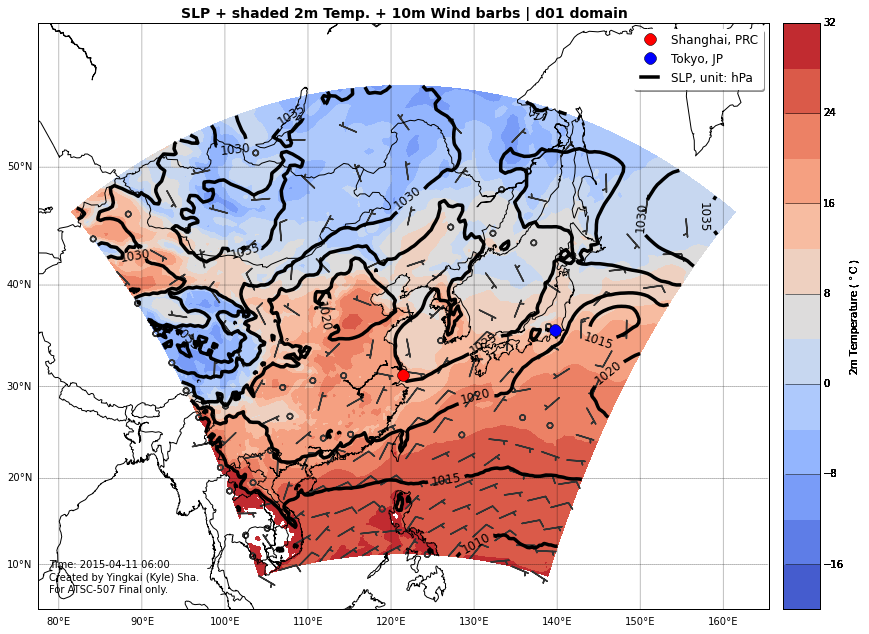

In [23]:
fig=plt.figure(figsize=(14, 14))
ani_obj=animation.FuncAnimation(fig, view2_movie_d01, range(9), \
                                init_func=init, interval=750, blit=True)
#writer_obj=animation.FFMpegFileWriter()
ani_obj.save('A507_Final_view2_d01.mov', metadata={'author':'Yingkai (Kyle) Sha'})

In [38]:
def view2_movie_d02(time_step):
    plt.cla()
    ax1=fig.gca()
    proj = draw_map(mapkeys02, 'k', 0.5)
    # transfer from Lat/Lon to projected grid
    x02, y02 = proj(lon02, lat02)
    shx, shy = proj(coor_sh[0], coor_sh[1])
    tkx, tky = proj(coor_tk[0], coor_tk[1])
    proj.plot(shx, shy, 'or', markersize=12, zorder=5, label='Shanghai, PRC')
    proj.plot(tkx, tky, 'ob', markersize=12, zorder=5, label='Tokyo, JP')
    # GPH isoline
    CS1=proj.contour(x02, y02, SLP02[time_step, :, :], SLPlev, colors = ('k',), linewidths=3.5)
    plt.clabel(CS1, SLPlev, inline=1, fmt='%1.0f', fontsize=12, fontweight='bold')
    CS1.collections[0].set_label('SLP, unit: hPa')
    # Shaded Temp.
    CS2=proj.contourf(x02, y02, T02[time_step, :, :], T2mlev, cmap=plt.cm.coolwarm) # RdBu_r
    CBar=proj.colorbar(CS2, location='right', size='5%', pad='2%')
    CBar.set_label('2m Temperature ( $\mathrm{^\circ C}$ )', fontsize=10)
    CBar.ax.tick_params(axis='y', length=35)
    # Wind barb
    proj.barbs(x02[::10, ::10], y02[::10, ::10], \
               u02[time_step, ::10, ::10], v02[time_step, ::10, ::10], \
               length=6, barbcolor=[0.2, 0.2, 0.2], flagcolor='r', linewidth=1.5)
    # legend
    legend=plt.legend(numpoints=1, shadow=True, fancybox=True, fontsize=12); 
    frame=legend.get_frame(); frame.set_color('white') 
    # text, title
    plt.text(x02[0, 0]*0.05, y02[120, 120]*0.5, 'Time: '+Time[time_step/3], fontsize=10)
    plt.text(x02[0, 0]*0.05, y02[120, 120]*0.05, SIGN, fontsize=10)
    plt.title('SLP + shaded 2m Temp. + 10m Wind barbs | d02 domain',\
                  fontweight='bold', fontsize=14)

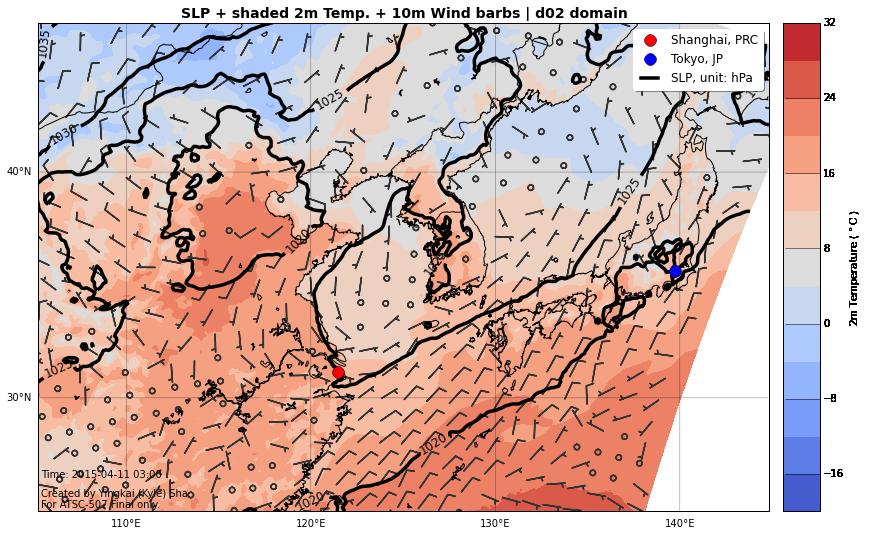

In [39]:
fig=plt.figure(figsize=(14, 14))
ani_obj=animation.FuncAnimation(fig, view2_movie_d02, range(23), \
                                init_func=init, interval=750, blit=True)
#writer_obj=animation.FFMpegFileWriter()
ani_obj.save('A507_Final_view2_d02.mov', metadata={'author':'Yingkai (Kyle) Sha'})

## Accumulated Total Grid Scale Precipitation

In [40]:
# d01
precip01 = d01_obj.variables['precip_g'][:]
# d02
precip02 = d02_obj.variables['precip_g'][:]

In [41]:
precip_lev = [0.5, 1, 2, 3, 4, 5, 7.5, 10, 20, 40, 100]

In [42]:
def view3_movie_d01(time_step):
    plt.cla()
    ax1=fig.gca()
    proj = draw_map(mapkeys01, 'k', 0.5)
    # transfer from Lat/Lon to projected grid
    x01, y01 = proj(lon01, lat01)
    shx, shy = proj(coor_sh[0], coor_sh[1])
    tkx, tky = proj(coor_tk[0], coor_tk[1])
    proj.plot(shx, shy, 'or', markersize=12, zorder=5, label='Shanghai, PRC')
    proj.plot(tkx, tky, 'ob', markersize=12, zorder=5, label='Tokyo, JP')
    # Shaded Temp.
    CS2=proj.contourf(x01, y01, precip01[time_step, :, :], precip_lev, \
                      cmap=nlcmap(plt.cm.gist_ncar_r, precip_lev), extend='both') # RdBu_r
    CBar=proj.colorbar(CS2, location='right', size='5%', pad='2%')
    CBar.set_label('Accumulated Total Grid Scale Precipitation ( mm )', fontsize=10)
    CBar.ax.tick_params(axis='y', length=35)
    # legend
    legend=plt.legend(numpoints=1, shadow=True, fancybox=True, fontsize=12); 
    frame=legend.get_frame(); frame.set_color('white') 
    # text, title
    plt.text(x01[0, 0]*0.05, y01[0, 0]*1.25, 'Time: '+Time[time_step], fontsize=10)
    plt.text(x01[0, 0]*0.05, y01[0, 0]*0.5, SIGN, fontsize=10)
    plt.title('Accumulated Total Grid Scale Precipitation | d01 domain',\
                  fontweight='bold', fontsize=14)

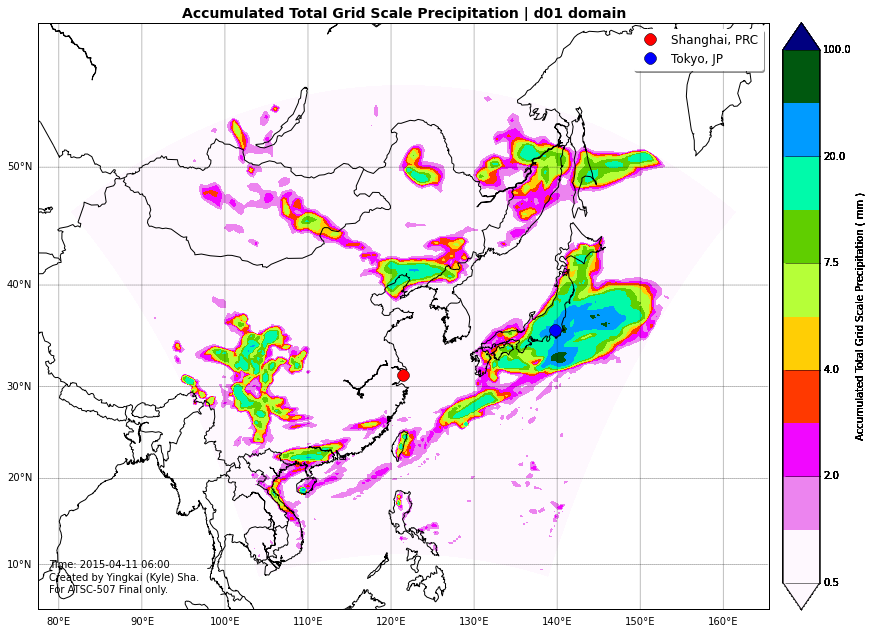

In [43]:
fig=plt.figure(figsize=(14, 14))
ani_obj=animation.FuncAnimation(fig, view3_movie_d01, range(9), \
                                init_func=init, interval=750, blit=True)
#writer_obj=animation.FFMpegFileWriter()
ani_obj.save('A507_Final_view3_d01.mov', metadata={'author':'Yingkai (Kyle) Sha'})

In [44]:
def view3_movie_d02(time_step):
    plt.cla()
    ax1=fig.gca()
    proj = draw_map(mapkeys02, 'k', 0.5)
    # transfer from Lat/Lon to projected grid
    x02, y02 = proj(lon02, lat02)
    shx, shy = proj(coor_sh[0], coor_sh[1])
    tkx, tky = proj(coor_tk[0], coor_tk[1])
    proj.plot(shx, shy, 'or', markersize=12, zorder=5, label='Shanghai, PRC')
    proj.plot(tkx, tky, 'ob', markersize=12, zorder=5, label='Tokyo, JP')
    # Shaded Temp.
    CS2=proj.contourf(x02, y02, precip02[time_step, :, :], precip_lev, \
                      cmap=nlcmap(plt.cm.gist_ncar_r, precip_lev), extend='both') # RdBu_r
    CBar=proj.colorbar(CS2, location='right', size='5%', pad='2%')
    CBar.set_label('Accumulated Total Grid Scale Precipitation ( mm )', fontsize=10)
    CBar.ax.tick_params(axis='y', length=35)
    # legend
    legend=plt.legend(numpoints=1, shadow=True, fancybox=True, fontsize=12); 
    frame=legend.get_frame(); frame.set_color('white')
    # text, title
    plt.text(x02[0, 0]*0.05, y02[120, 120]*0.5, 'Time: '+Time[time_step/3], fontsize=10)
    plt.text(x02[0, 0]*0.05, y02[120, 120]*0.05, SIGN, fontsize=10)
    plt.title('Accumulated Total Grid Scale Precipitation | d02 domain',\
                  fontweight='bold', fontsize=14)

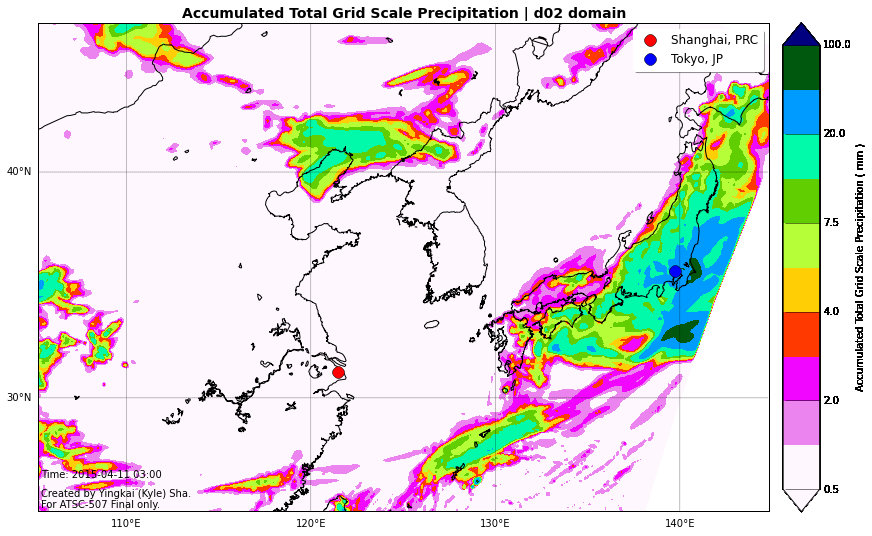

In [45]:
fig=plt.figure(figsize=(14, 14))
ani_obj=animation.FuncAnimation(fig, view3_movie_d02, range(23), \
                                init_func=init, interval=750, blit=True)
#writer_obj=animation.FFMpegFileWriter()
ani_obj.save('A507_Final_view3_d02.mov', metadata={'author':'Yingkai (Kyle) Sha'})

# Meteogram

Applying *k-dimensional tree* reconstruct the grids and search the nearest grid for two cities.

Here I only do meteogram for nested d02 domain, because they are more detailed for forecasting a point.

In [46]:
RH02 = d02_obj.variables['rh_2m'][:]

In [47]:
x_city, y_city = nearest_kdtree(lon02, lat02, \
                            np.array([coor_sh[0], coor_tk[0]]), np.array([coor_sh[1], coor_tk[1]]))

In [48]:
SLPm = SLP02[:, x_city, y_city]
T2mm = T02[:, x_city, y_city]
u02m = u02[:, x_city, y_city]
v02m = v02[:, x_city, y_city]
RH02m = RH02[:, x_city, y_city]
precipm = precip02[:, x_city, y_city]
proxy_x = np.arange(24)

In [49]:
def draw_meteo(hit, title):
    fig = plt.figure(figsize=(12, 7.5))
    ax1 = plt.subplot2grid((5, 1), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((5, 1), (1, 0), colspan=1, rowspan=1)
    ax3 = plt.subplot2grid((5, 1), (2, 0), colspan=1, rowspan=1)
    ax4 = plt.subplot2grid((5, 1), (3, 0), colspan=1, rowspan=1)
    ax5 = plt.subplot2grid((5, 1), (4, 0), colspan=1, rowspan=1)
    # rm xlabel
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
    ax3.xaxis.set_major_formatter(plt.NullFormatter())
    ax4.xaxis.set_major_formatter(plt.NullFormatter())
    # SLP
    ax1.plot(proxy_x, SLPm[:, hit], 'k-', linewidth=3)
    ax1.set_xlim(0, 23); ax1.set_ylim(1015, 1027); ax1.grid()
    ax1.set_title(title, fontsize=14, fontweight='bold')
    # 2m Temp
    ax2.plot(proxy_x, T2mm[:, hit], 'r-', linewidth=3)
    ax2.set_xlim(0, 23); ax2.set_ylim(8, 18); ax2.grid()
    # 2m RH
    ax3.plot(proxy_x, RH02m[:, hit], 'g-', linewidth=3)
    ax3.set_xlim(0, 23); ax3.set_ylim(40, 100); ax3.grid()
    # precip
    ax4.plot(proxy_x, precipm[:, hit], 'b-', linewidth=3)
    ax4.set_xlim(0, 23); ax4.set_ylim(0, 30); ax4.grid()
    # wind barb
    ax5.barbs(u02m[:, hit], v02m[:, hit], length=6, linewidth=2); 
    ax5.set_xlim(0, 23); ax5.set_ylim(-0.3, 0.3); ax5.grid(); ax5.set_xticklabels(Time)

##Shanghai, PRC

According to the <a href='http://www.wunderground.com/history/airport/ZSSS/2015/4/10/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo='>observation</a> on Shanghai's Hongqiao Airport, on Apr 10:
* Maximum temperature: 18°C
* Minium temperature: 10°C 
* Average temperature: 14°C
* Sea level pressure: 1022.98hPa
* Maximum humidity: 82%
* Minimim humidity: 37%
* Average humidity: 62%
* Weather: Sunny
* Average wind speed: 8 km/h (4.3 knots)

And this is the meteogram based on WRF run:

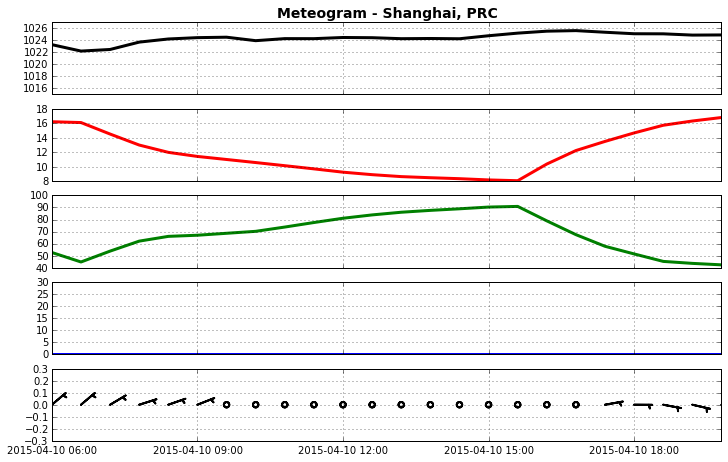

In [50]:
draw_meteo(0, 'Meteogram - Shanghai, PRC')

## Tokyo, JP

According to the <a href='http://www.wunderground.com/history/airport/RJTT/2015/4/10/DailyHistory.html?req_city=%E6%9D%B1%E4%BA%AC&req_state=&req_statename=%E6%97%A5%E6%9C%AC&reqdb.zip=00000&reqdb.magic=1&reqdb.wmo=47671&MR=1'>observation</a> on Tokyo's Haneda Airport, on Apr 10:

* Maximum temperature: 12°C
* Minium temperature: 10°C 
* Average temperature: 11°C
* Sea level pressure: 1024.06hPa
* Maximum humidity: 93%
* Minimim humidity: 58%
* Average humidity: 76%
* Weather: half-rain
* Average wind speed: 15 km/h (8 knots)

And this is the meteogram based on WRF run:

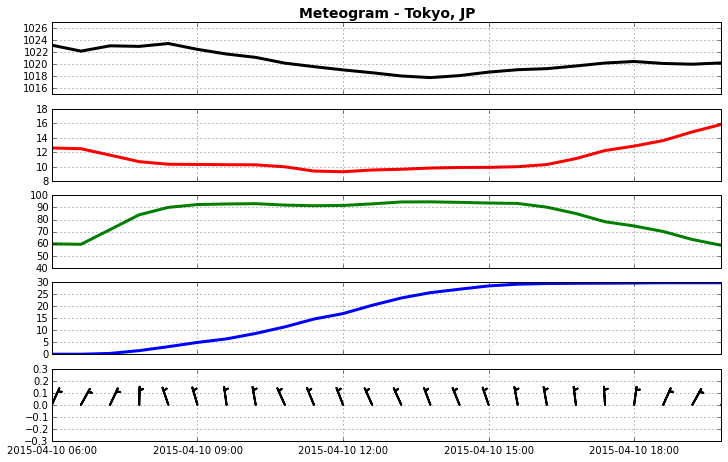

In [51]:
draw_meteo(1, 'Meteogram - Tokyo, JP')

## Short summary

* WRF did very well for forecasting surface conditions on both *Shanghai* and *Tokyo* for a 24 hour forecast.
* The weather conditions on *Shanghai* and *Tokyo* different on temperature, precipitation and horizontal surface wind. The reason is the different circulation patterns behind and in front of the 500hPa trough.